<a href="https://colab.research.google.com/github/Ajay-user/DataScience/blob/master/Classification%20Problems/Pet_Finder_Structured_Data_Classification_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Binary classification problem, simply predict whether the pet was adopted, or not.

In [176]:
import pandas as pd
import numpy as np
import tensorflow as tf
import pathlib
from sklearn.model_selection import train_test_split

## Download the Data

In [4]:
dataset_url = 'http://storage.googleapis.com/download.tensorflow.org/data/petfinder-mini.zip'

data_dir = tf.keras.utils.get_file(fname='petfinder_mini.zip', origin=dataset_url, extract=True, cache_dir='.', cache_subdir='')

1679360/1668792 [==============================] - 0s 0us/step


In [5]:
parent_dir = pathlib.Path(data_dir).parent
for dir in parent_dir.iterdir():
  print(dir)

.config
petfinder_mini.zip
__MACOSX
petfinder-mini
sample_data


In [6]:
pet_data_dir = parent_dir/'petfinder-mini'
for dir in pet_data_dir.iterdir():
  print(dir)

petfinder-mini/petfinder-mini.csv
petfinder-mini/README.md


Load the CSV file

In [7]:
# trainig data dir
pet_data_csv = pet_data_dir/'petfinder-mini.csv'
# create a dataframe using the dir
df = pd.read_csv(pet_data_csv)

In [8]:
df.head(3)

,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,Description,PhotoAmt,AdoptionSpeed
0,Cat,3,Tabby,Male,Black,White,Small,Short,No,No,Healthy,100,Nibble is a 3+ month old ball of cuteness. He ...,1,2
1,Cat,1,Domestic Medium Hair,Male,Black,Brown,Medium,Medium,Not Sure,Not Sure,Healthy,0,I just found it alone yesterday near my apartm...,2,0
2,Dog,1,Mixed Breed,Male,Brown,White,Medium,Medium,Yes,No,Healthy,0,Their pregnant mother was dumped by her irresp...,7,3


**Create Target Variable**

Modifying the `AdoptionSpeed` column for binary classifiaction, `0` will indicate the pet was not adopted, and `1` will indicate it was.

* 0 - Pet was adopted on the same day as it was listed.
* 1 - Pet was adopted between 1 and 7 days (1st week) after being listed.
* 2 - Pet was adopted between 8 and 30 days (1st month) after being listed.
* 3 - Pet was adopted between 31 and 90 days (2nd & 3rd month) after being listed.
* 4 - No adoption after 100 days of being listed. (There are no pets in this dataset that waited between 90 and 100 days).

Label:2 count:3153
Label:4 count:3080
Label:3 count:2543
Label:1 count:2432
Label:0 count:329


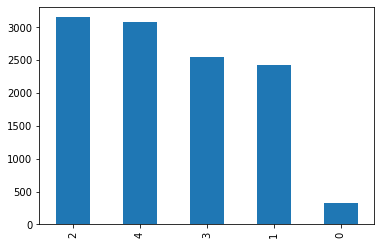

In [22]:
adopt = df['AdoptionSpeed'].value_counts()
for label, count in zip(adopt.index, adopt.values):
  print(f'Label:{label} count:{count}')
df['AdoptionSpeed'].value_counts().plot(kind='bar');

In [24]:
X = df.copy()
X['Target'] = np.where(X['AdoptionSpeed']==4, 0, 1)
X = X.drop(columns=['AdoptionSpeed', 'Description'])

Label:1 count:8457
Label:0 count:3080


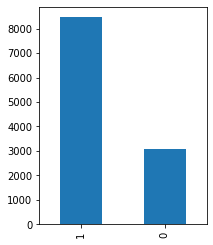

In [31]:
target = X['Target'].value_counts()
for label, count in zip(target.index, target.values):
  print(f'Label:{label} count:{count}')
X['Target'].value_counts().plot(kind='bar', figsize=(3,4));

**Split the dataframe into Train, Validation, and Test**

In [37]:
train, test = train_test_split(X, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)

print('Length of training data', len(train))
print('Length of validation data', len(val))
print('Length of testing data', len(test))

Length of training data 7383
Length of validation data 1846
Length of testing data 2308


In [111]:
# number of unique data in training data
u = train.nunique()
for col, count in zip(u.index, u.values):
  print(f'{col !s:13} {count !s:4} {train[col].dtype}')

Type          2    object
Age           91   int64
Breed1        152  object
Gender        2    object
Color1        7    object
Color2        7    object
MaturitySize  3    object
FurLength     3    object
Vaccinated    3    object
Sterilized    3    object
Health        3    object
Fee           54   int64
PhotoAmt      31   int64
Target        2    int64


## Create an Input pipeline using `tf.data`

In [41]:
# utitlity for converting dataframe into dataset
def df_to_ds(df, batch_size, shuffle=False):
  df = df.copy()
  target = df.pop('Target')
  
  ds = tf.data.Dataset.from_tensor_slices((dict(df), target))
  
  if shuffle:
    ds = ds.shuffle(buffer_size=len(df))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
  return ds

In [42]:
# convert the dataframe to dataset
train_ds = df_to_ds(df=train, batch_size=32, shuffle=True)
val_ds = df_to_ds(df=val, batch_size=32)
test_ds = df_to_ds(df=test, batch_size=32)

In [86]:
feature_batch, label_batch = next(iter(train_ds))
for i, (key, val) in enumerate(feature_batch.items()):
  print(f'{i} {key:12} {val.dtype !s:20} {val.numpy()[:1]}')

0 Type         <dtype: 'string'>    [b'Cat']
1 Age          <dtype: 'int64'>     [12]
2 Breed1       <dtype: 'string'>    [b'Tortoiseshell']
3 Gender       <dtype: 'string'>    [b'Female']
4 Color1       <dtype: 'string'>    [b'Black']
5 Color2       <dtype: 'string'>    [b'Brown']
6 MaturitySize <dtype: 'string'>    [b'Medium']
7 FurLength    <dtype: 'string'>    [b'Short']
8 Vaccinated   <dtype: 'string'>    [b'No']
9 Sterilized   <dtype: 'string'>    [b'No']
10 Health       <dtype: 'string'>    [b'Healthy']
11 Fee          <dtype: 'int64'>     [0]
12 PhotoAmt     <dtype: 'int64'>     [1]


## Preprocessing layers

* `Normalization` - Feature-wise normalization of the data.
* `CategoryEncoding` - Category encoding layer.
* `StringLookup` - Maps strings from a vocabulary to integer indices.
* `IntegerLookup` - Maps integers from a vocabulary to integer indices.

**Numeric columns**
For each of the Numeric feature, you will use a Normalization() layer to make sure the mean of each feature is 0 and its standard deviation is 1.

**Categorical columns**
In this dataset, Type is represented as a string (e.g. 'Dog', or 'Cat'). You cannot feed strings directly to a model. The preprocessing layer takes care of representing strings as a one-hot vector.

Utiltiy for encoding numerical features

In [91]:
def encode_neumerical(feature ,feature_name, dataset):
  # initializie
  normalizer = tf.keras.layers.Normalization()
  # get the desired feature
  feature_ds = dataset.map(lambda x,y: x[feature_name])
  feature_ds =  feature_ds.map(lambda x: tf.expand_dims(x, axis=-1))
  # Learn the statistics of the data. (mean , var, std)
  normalizer.adapt(feature_ds)
  return normalizer(feature)

Utiltiy for encoding Categorical features


In [168]:
def encode_categorical(feature, feature_name, dataset, is_string=True, max_tokens=None, is_discrete=True):
  # initialize the lookup class
  lookup = tf.keras.layers.StringLookup(max_tokens=max_tokens) if is_string else tf.keras.layers.IntegerLookup(max_tokens=max_tokens)
  # get the desired feature
  feature_ds = dataset.map(lambda x,y: x[feature_name])
  feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))
  # Learn the set of possible values and assign them a fixed integer index.
  lookup.adapt(feature_ds)

  if is_discrete:
      # Create a Discretization for our integer indices.
      discretize = tf.keras.layers.CategoryEncoding(num_tokens=lookup.vocabulary_size())
      # Apply one-hot encoding to our indices.
      return discretize(lookup(feature))
  else:
    # return the indices 
    return lookup(feature)

In [160]:
# integer_categorical
int_cat = []
# string _categorical
str_cat = []

def add_col(col_type):
  if train[col].dtype == 'object':
    str_cat.append(col)
  else:
    int_cat.append(col)


for col in train.columns:
  if col != 'Target':
    if train[col].nunique()<10:
      add_col(train[col].dtype)

In [117]:
print('The following features are categorical features encoded as string:\n',str_cat)

The following features are categorical features encoded as string:
 ['Type', 'Gender', 'Color1', 'Color2', 'MaturitySize', 'FurLength', 'Vaccinated', 'Sterilized', 'Health']


In [172]:
all_inputs = []
all_encoded_inputs = []

# preprocessing string category
for feature in str_cat:
  input_feature = tf.keras.Input(shape=(1,), name=feature, dtype='string')
  all_inputs.append(input_feature)
  encoded_feature = encode_categorical(feature=input_feature, feature_name=feature, dataset=train_ds)
  all_encoded_inputs.append(encoded_feature)


In [173]:
numerical_columns = ['Age', 'PhotoAmt', 'Fee']
string_column = ['Breed1']

for feature in numerical_columns:
  input_feature = tf.keras.Input(shape=(1,), name=feature, dtype='int64')
  all_inputs.append(input_feature)
  encoded_feature = encode_neumerical(feature=input_feature, feature_name=feature, dataset=train_ds)
  all_encoded_inputs.append(encoded_feature)

for feature in string_column:
  input_feature = tf.keras.Input(shape=(1,), name=feature, dtype='string')
  all_inputs.append(input_feature)
  encoded_feature = encode_categorical(feature=input_feature, feature_name=feature, dataset=train_ds)
  all_encoded_inputs.append(encoded_feature)


## Model Building

In [175]:
encoded_inputs = tf.keras.layers.concatenate(all_encoded_inputs)
x = tf.keras.layers.Dense(units=32, activation='relu')(encoded_inputs)
x = tf.keras.layers.Dropout(rate=0.5)(x)
output = tf.keras.layers.Dense(units=1)(x)
model  = tf.keras.Model(all_inputs, output)

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

plot the model

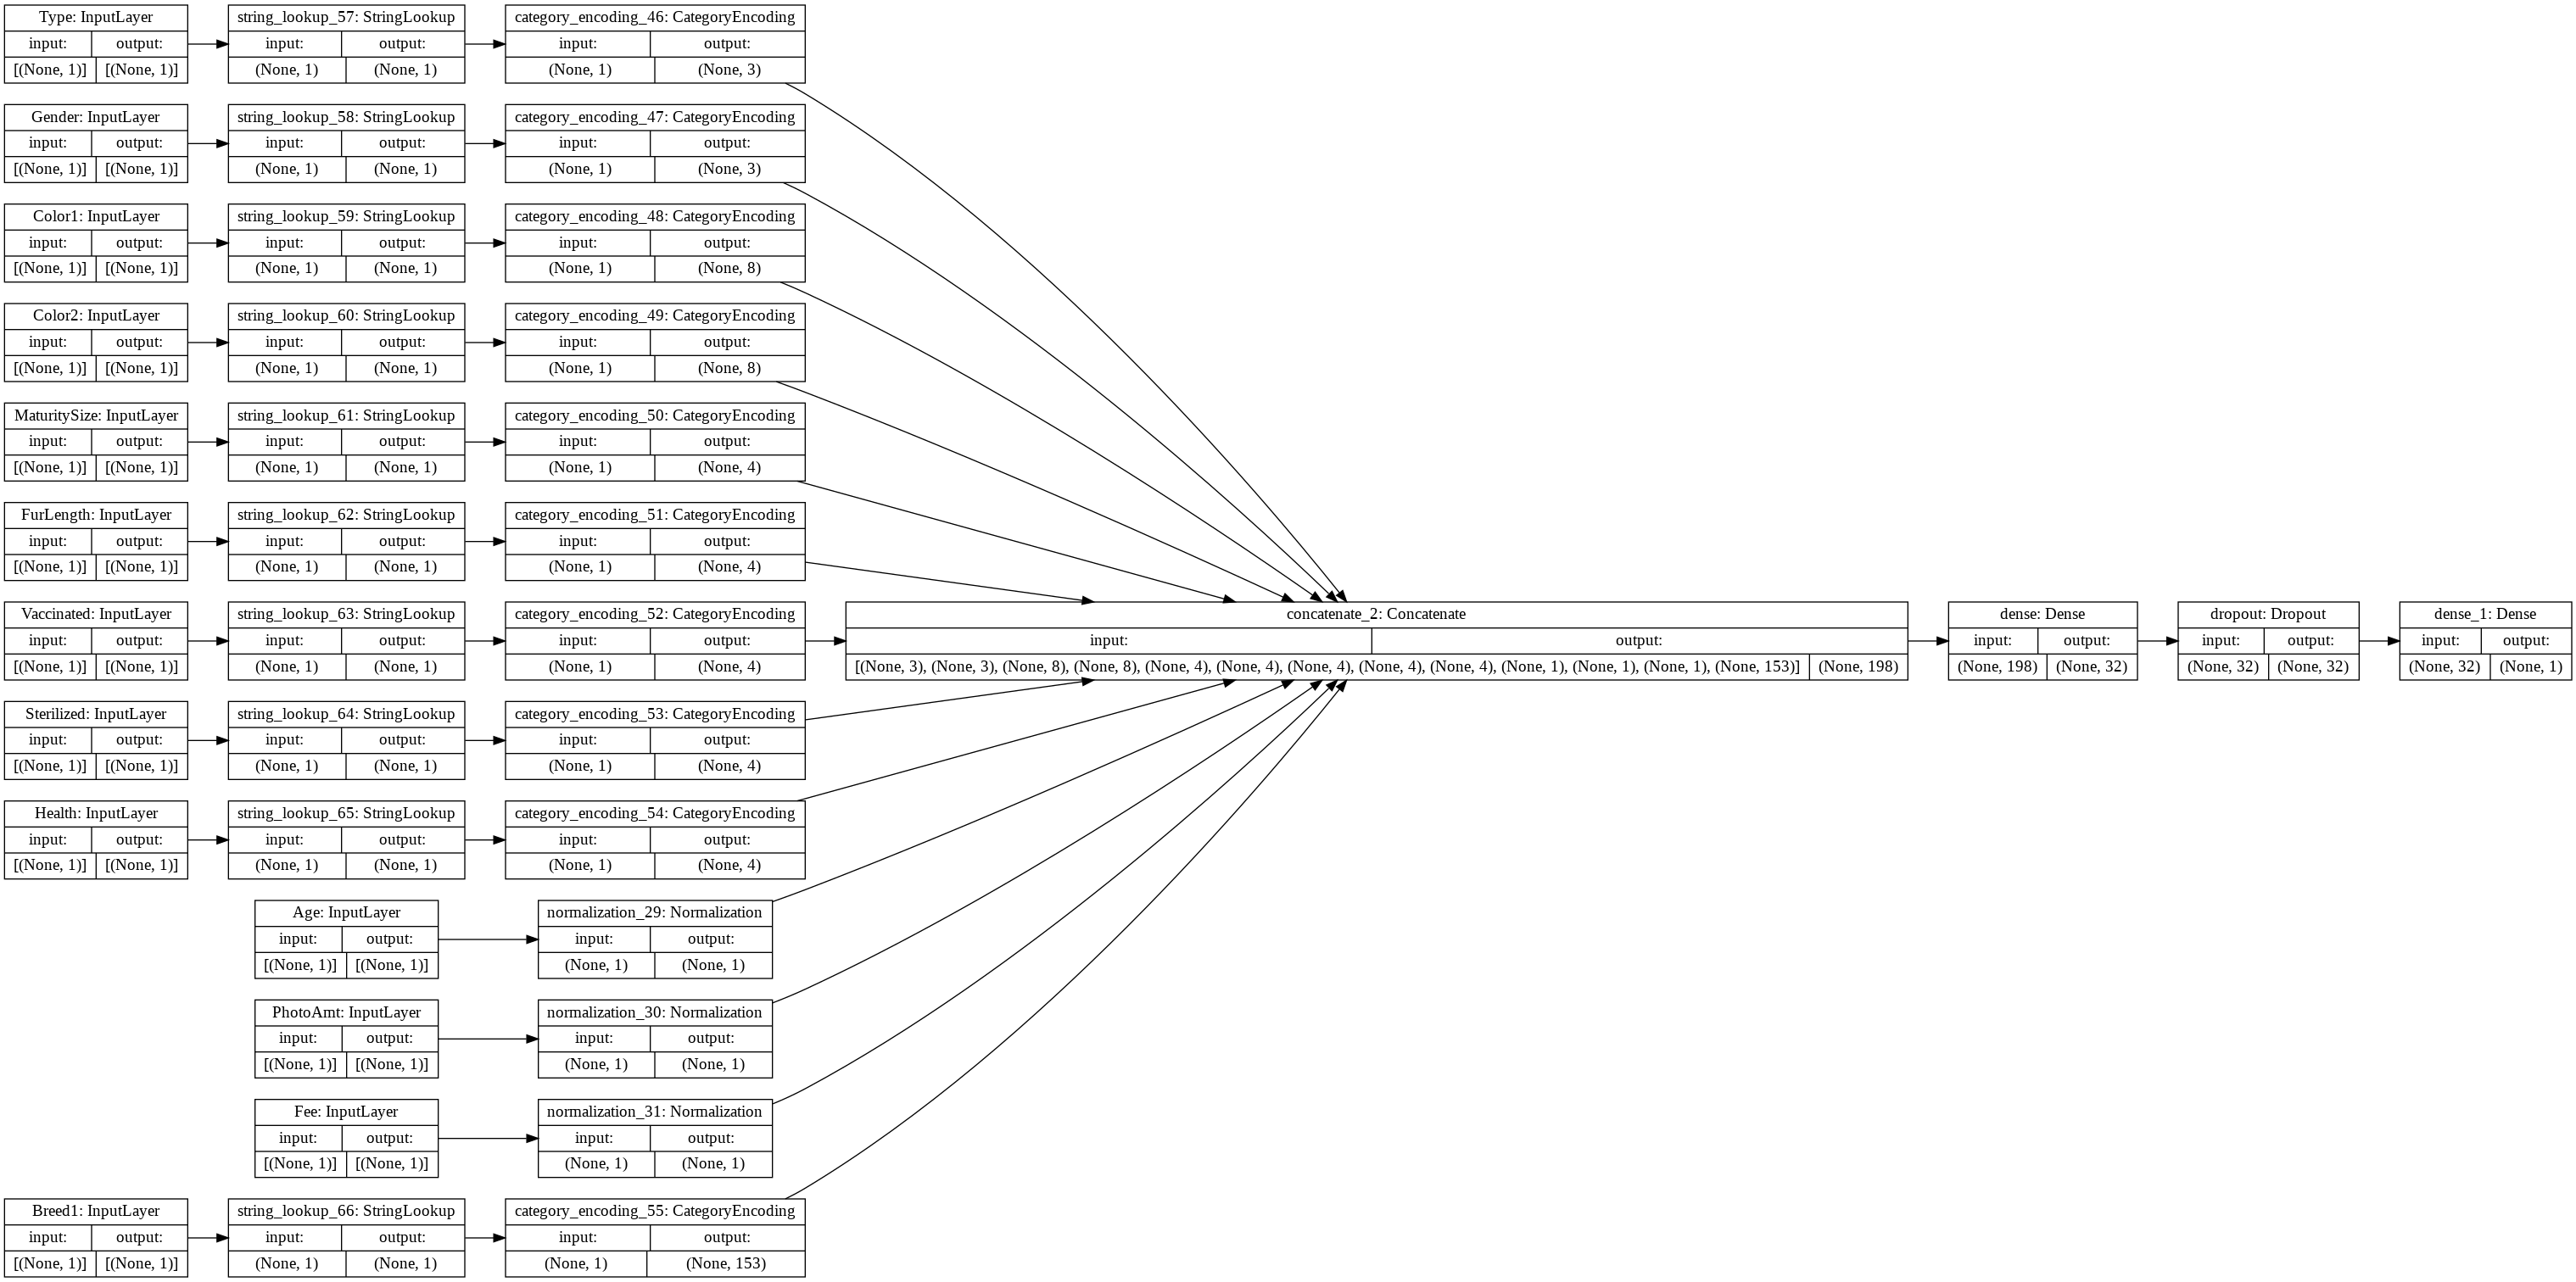

In [177]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir='LR')

In [178]:
# training
history = model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
231/231 [==============================] - 3s 5ms/step - loss: 0.5707 - accuracy: 0.6733 - val_loss: 0.5685 - val_accuracy: 0.7075
Epoch 2/10
231/231 [==============================] - 1s 3ms/step - loss: 0.5438 - accuracy: 0.7119 - val_loss: 0.5555 - val_accuracy: 0.7102
Epoch 3/10
231/231 [==============================] - 1s 3ms/step - loss: 0.5317 - accuracy: 0.7219 - val_loss: 0.5508 - val_accuracy: 0.7167
Epoch 4/10
231/231 [==============================] - 1s 3ms/step - loss: 0.5234 - accuracy: 0.7320 - val_loss: 0.5445 - val_accuracy: 0.7194
Epoch 5/10
231/231 [==============================] - 1s 3ms/step - loss: 0.5185 - accuracy: 0.7321 - val_loss: 0.5426 - val_accuracy: 0.7243
Epoch 6/10
231/231 [==============================] - 1s 4ms/step - loss: 0.5141 - accuracy: 0.7391 - val_loss: 0.5352 - val_accuracy: 0.7313
Epoch 7/10
231/231 [==============================] - 1s 3ms/step - loss: 0.5117 - accuracy: 0.7387 - val_loss: 0.5327 - val_accuracy: 0.7248
Epoch 

In [179]:
loss, accuracy = model.evaluate(test_ds)
print('Loss ', loss)
print('Accuracy', accuracy)

73/73 [==============================] - 0s 2ms/step - loss: 0.5047 - accuracy: 0.7448
Loss  0.5046562552452087
Accuracy 0.7448006868362427


## Inference on new data

In [180]:
sample = {
    'Type': 'Cat',
    'Age': 3,
    'Breed1': 'Tabby',
    'Gender': 'Male',
    'Color1': 'Black',
    'Color2': 'White',
    'MaturitySize': 'Small',
    'FurLength': 'Short',
    'Vaccinated': 'No',
    'Sterilized': 'No',
    'Health': 'Healthy',
    'Fee': 100,
    'PhotoAmt': 2,
}

In [184]:
sample_dict = {k:tf.convert_to_tensor([v]) for k,v in sample.items()}
predictions = model.predict(sample_dict)
probability = tf.nn.sigmoid(predictions)

In [187]:
print(f'This particular pet had a {probability.numpy()[0][0] :.3f}% percent probability of getting adopted.')

This particular pet had a 0.767% percent probability of getting adopted.
